<a href="https://colab.research.google.com/github/brgsil/toxicity-lm-ia024/blob/main/Stereoset_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import json
import csv
import os
import time
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install bitsandbytes

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from accelerate import Accelerator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 2.5 MB/s 
     |████████████████████████████████| 182 kB 59.0 MB/s 
     |████████████████████████████████| 7.6 MB 44.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.3 MB/s 
     |████████████████████████████████| 115 kB 69.4 MB/s 
     |████████████████████████████████| 212 kB 49.3 MB/s 
     |████████████████████████████████| 127 kB 58.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
   accelerator = Accelerator(mixed_precision='fp16')
else: 
   dev = "cpu"
   accelerator = Accelerator(mixed_precision='no')
#device = torch.device(dev)
device = accelerator.device
print('Using {}'.format(device))

Using cpu


In [ ]:
class StereosetDataset(Dataset):

    def __init__(self, tokenizer, mode = 'intersentence'):

        self.mode = mode

        dataset1 = load_dataset('stereoset', 'intersentence', split="validation")
        dataset2 = load_dataset('stereoset', 'intrasentence', split="validation")

        self.task_type = []
        self.bias_type = []

        anti_stereo = []
        stereo = []
        unrelated = []

        no_context_anti_stereo = []
        no_context_stereo = []
        no_context_unrelated = []

        bos_token = '' if 'opt' in tokenizer.name_or_path else tokenizer.bos_token

        # Intersentence
        for data in dataset1:
            self.bias_type.append(data['bias_type'])
            labels = data['sentences']['gold_label']
            context = data['context'] if data['context'][-1] in [".", "!", "?"] else data['context'][-1] + '.'

            anti_stereo.append(bos_token + context + ' ' + data['sentences']['sentence'][labels.index(0)])
            no_context_anti_stereo.append(bos_token + data['sentences']['sentence'][labels.index(0)])

            stereo.append(bos_token + context + ' ' + data['sentences']['sentence'][labels.index(1)])
            no_context_stereo.append(bos_token + data['sentences']['sentence'][labels.index(1)])

            unrelated.append(bos_token + context + ' ' + data['sentences']['sentence'][labels.index(2)])
            no_context_unrelated.append(bos_token + data['sentences']['sentence'][labels.index(2)])

            self.task_type.append('intersentence')

        # Intrasentence
        for data in dataset2:
            self.bias_type.append(data['bias_type'])
            labels = data['sentences']['gold_label']
            anti_stereo.append(bos_token + data['sentences']['sentence'][labels.index(0)])
            stereo.append(bos_token + data['sentences']['sentence'][labels.index(1)])
            unrelated.append(bos_token + data['sentences']['sentence'][labels.index(2)])
            self.task_type.append('intrasentence')
    
        
        self.anti_stereo = tokenizer(anti_stereo, padding=True, return_tensors='pt')
        self.stereo = tokenizer(stereo, padding=True, return_tensors='pt')
        self.unrelated = tokenizer(unrelated, padding=True, return_tensors='pt')

        self.no_context_anti_stereo = tokenizer(no_context_anti_stereo, padding=True, return_tensors='pt')
        self.no_context_stereo = tokenizer(no_context_stereo, padding=True, return_tensors='pt')
        self.no_context_unrelated = tokenizer(no_context_unrelated, padding=True, return_tensors='pt')

        self.task_type = np.asarray(self.task_type)
        self.bias_type = np.asarray(self.bias_type)

    def set_mode(self, mode): # Should only be intersentence or intrasentence
        self.mode = mode

    def __len__(self):
        return len(self.task_type[self.task_type == self.mode])
    
    def __getitem__(self, index):
        if self.mode == 'intrasentence':
            to_return = (self.anti_stereo.input_ids[self.task_type == self.mode][index],
                        self.anti_stereo.attention_mask[self.task_type == self.mode][index],
                        self.stereo.input_ids[self.task_type == self.mode][index],
                        self.stereo.attention_mask[self.task_type == self.mode][index],
                        self.unrelated.input_ids[self.task_type == self.mode][index],
                        self.unrelated.attention_mask[self.task_type == self.mode][index],
                        self.bias_type[self.task_type == self.mode][index],
                        self.task_type[self.task_type == self.mode][index])
        else:
            to_return = (self.anti_stereo.input_ids[self.task_type == self.mode][index],
                        self.anti_stereo.attention_mask[self.task_type == self.mode][index],
                        self.no_context_anti_stereo.input_ids[index],
                        self.no_context_anti_stereo.attention_mask[index],
                        self.stereo.input_ids[self.task_type == self.mode][index],
                        self.stereo.attention_mask[self.task_type == self.mode][index],
                        self.no_context_stereo.input_ids[index],
                        self.no_context_stereo.attention_mask[index],
                        self.unrelated.input_ids[self.task_type == self.mode][index],
                        self.unrelated.attention_mask[self.task_type == self.mode][index],
                        self.no_context_unrelated.input_ids[index],
                        self.no_context_unrelated.attention_mask[index],
                        self.bias_type[self.task_type == self.mode][index],
                        self.task_type[self.task_type == self.mode][index])


        return to_return

# 3) Geração de textos pelos modelos

## 3.1) Modelos a serem avaliados

In [ ]:
test_models = ["EleutherAI/gpt-neo-125M",
               "EleutherAI/gpt-neo-1.3B",
               "EleutherAI/gpt-neo-2.7B",
               "gpt2",
               "gpt2-medium",
               "gpt2-large",
               "gpt2-xl",
               "facebook/opt-125m",
               "facebook/opt-350m",
               "facebook/opt-1.3b",
               "facebook/opt-2.7b",
               "facebook/opt-6.7b",
               "facebook/galactica-125m",
               "facebook/galactica-1.3b",
               "facebook/galactica-6.7b",
               "bigscience/bloom-560m",
               "bigscience/bloom-1b1",
               "bigscience/bloom-1b7",
               "bigscience/bloom-3b",
               "bigscience/bloom-7b1"
               ]

## 3.2) Loop para avaliar probabilidades e contar corretos

In [ ]:
def evaluate_intrasentence(loader, model, summary):
    pbar = tqdm(loader, total=len(loader))

    with torch.no_grad():
        for batch in pbar:
            anti_stereo_ids = batch[0]
            anti_stereo_mask = batch[1]
            stereo_ids = batch[2]
            stereo_mask = batch[3]
            unrelated_ids = batch[4]
            unrelated_mask = batch[5]
            bias_type = batch[6]
            task_type = batch[7]

            logits = model(anti_stereo_ids, attention_mask=anti_stereo_mask).logits
            soft = torch.nn.functional.softmax(logits, dim=-1)
            probs = torch.vstack([soft[i,:-1,:][torch.arange(soft.shape[1]-1), anti_stereo_ids[i, 1:]] for i in range(soft.shape[0])])
            probs[anti_stereo_mask[:, 1:] == 0] = 1.0
            anti_stereo_scores = torch.pow(2, torch.log2(probs).sum(dim=1) / anti_stereo_mask[:, 1:].sum(dim=1)).cpu()
            
            logits = model(stereo_ids, attention_mask=stereo_mask).logits
            soft = torch.nn.functional.softmax(logits, dim=-1)
            probs = torch.vstack([soft[i,:-1,:][torch.arange(soft.shape[1]-1), stereo_ids[i, 1:]] for i in range(soft.shape[0])])
            probs[stereo_mask[:, 1:] == 0] = 1.0
            stereo_scores = torch.pow(2, torch.log2(probs).sum(dim=1) / stereo_mask[:, 1:].sum(dim=1)).cpu()
            
            logits = model(unrelated_ids, attention_mask=unrelated_mask).logits
            soft = torch.nn.functional.softmax(logits, dim=-1)
            probs = torch.vstack([soft[i,:-1,:][torch.arange(soft.shape[1]-1), unrelated_ids[i, 1:]] for i in range(soft.shape[0])])
            probs[unrelated_mask[:, 1:] == 0] = 1.0
            unrelated_scores = torch.pow(2, torch.log2(probs).sum(dim=1) / unrelated_mask[:, 1:].sum(dim=1)).cpu()

            for bias in summary['intrasentence'].keys():
                bias_mask = torch.from_numpy(np.asarray(bias_type) == bias)
                count_anti_stereo = torch.sum((anti_stereo_scores * bias_mask) > (stereo_scores * bias_mask))
                count_unrelated = torch.sum(unrelated_scores * bias_mask > anti_stereo_scores * bias_mask) + torch.sum(unrelated_scores * bias_mask > stereo_scores * bias_mask)
                summary['intrasentence'][bias]['anti_stero'] += count_anti_stereo.item()
                summary['intrasentence'][bias]['stereo'] += (torch.sum(bias_mask).item() - count_anti_stereo.item())
                summary['intrasentence'][bias]['unrelated'] += count_unrelated.item()
            
    return summary

In [ ]:
def evaluate_intersentence(loader, model, summary):
    pbar = tqdm(loader, total=len(loader))

    with torch.no_grad():
        for batch in pbar:
            anti_stereo_ids = batch[0]
            anti_stereo_mask = batch[1]
            no_context_anti_stereo_ids = batch[2]
            no_context_anti_stereo_mask = batch[3]
            stereo_ids = batch[4]
            stereo_mask = batch[5]
            no_context_stereo_ids = batch[6]
            no_context_stereo_mask = batch[7]
            unrelated_ids = batch[8]
            unrelated_mask = batch[9]
            no_context_unrelated_ids = batch[10]
            no_context_unrelated_mask = batch[11]
            bias_type = batch[12]
            task_type = batch[13]

            # Anti-stereotypical score
            len_sentence = torch.sum(no_context_anti_stereo_ids != tokenizer.pad_token_id, dim=1)
            len_context = torch.sum(anti_stereo_ids != tokenizer.pad_token_id, dim=1) - torch.sum(no_context_anti_stereo_ids != tokenizer.pad_token_id, dim=1)
            shape = anti_stereo_ids.shape
            logits = model(anti_stereo_ids, attention_mask=anti_stereo_mask).logits
            soft = torch.nn.functional.softmax(logits, dim=-1)
            probs = torch.vstack([soft[i,:-1,:][torch.arange(soft.shape[1]-1), anti_stereo_ids[i, 1:]] for i in range(soft.shape[0])])
            a = torch.arange(shape[1] - 1).expand(shape[0], shape[1] - 1).to(device)
            probs[((a - len_context.reshape(len_context.shape[0], 1)) < 0 )] = 1.0
            probs[anti_stereo_mask[:, 1:] == 0] = 1.0
            loss_anti_stereo = torch.sum(torch.log2(probs), dim=1) / len_sentence

            logits = model(no_context_anti_stereo_ids, attention_mask=no_context_anti_stereo_mask).logits
            soft = torch.nn.functional.softmax(logits, dim=-1)
            probs = torch.vstack([soft[i,:-1,:][torch.arange(soft.shape[1]-1), no_context_anti_stereo_ids[i, 1:]] for i in range(soft.shape[0])])
            probs[no_context_anti_stereo_mask[:, 1:] == 0] = 1.0
            loss_no_context_anti_stereo = torch.log2(probs).sum(dim=1) / len_sentence

            score_anti_stereo = (loss_anti_stereo - loss_no_context_anti_stereo).cpu()

            # Stereotypical score
            len_sentence = torch.sum(no_context_stereo_ids != tokenizer.pad_token_id, dim=1)
            len_context = torch.sum(stereo_ids != tokenizer.pad_token_id, dim=1) - torch.sum(no_context_stereo_ids != tokenizer.pad_token_id, dim=1)
            shape = stereo_ids.shape
            logits = model(stereo_ids, attention_mask=stereo_mask).logits
            soft = torch.nn.functional.softmax(logits, dim=-1)
            probs = torch.vstack([soft[i,:-1,:][torch.arange(soft.shape[1]-1), stereo_ids[i, 1:]] for i in range(soft.shape[0])])
            a = torch.arange(shape[1] - 1).expand(shape[0], shape[1] - 1).to(device)
            probs[((a - len_context.reshape(len_context.shape[0], 1)) < 0 )] = 1.0
            probs[stereo_mask[:, 1:] == 0] = 1.0
            loss_stereo = torch.sum(torch.log2(probs), dim=1) / len_sentence

            logits = model(no_context_stereo_ids, attention_mask=no_context_stereo_mask).logits
            soft = torch.nn.functional.softmax(logits, dim=-1)
            probs = torch.vstack([soft[i,:-1,:][torch.arange(soft.shape[1]-1), no_context_stereo_ids[i, 1:]] for i in range(soft.shape[0])])
            probs[no_context_stereo_mask[:, 1:] == 0] = 1.0
            loss_no_context_stereo = torch.log2(probs).sum(dim=1) / len_sentence

            score_stereo = (loss_stereo - loss_no_context_stereo).cpu()

            # Unrelated score
            len_sentence = torch.sum(no_context_unrelated_ids != tokenizer.pad_token_id, dim=1)
            len_context = torch.sum(unrelated_ids != tokenizer.pad_token_id, dim=1) - torch.sum(no_context_unrelated_ids != tokenizer.pad_token_id, dim=1)
            shape = unrelated_ids.shape
            logits = model(unrelated_ids, attention_mask=unrelated_mask).logits
            soft = torch.nn.functional.softmax(logits, dim=-1)
            probs = torch.vstack([soft[i,:-1,:][torch.arange(soft.shape[1]-1), unrelated_ids[i, 1:]] for i in range(soft.shape[0])])
            a = torch.arange(shape[1] - 1).expand(shape[0], shape[1] - 1).to(device)
            probs[((a - len_context.reshape(len_context.shape[0], 1)) < 0 )] = 1.0
            probs[unrelated_mask[:, 1:] == 0] = 1.0
            loss_unrelated = torch.sum(torch.log2(probs), dim=1) / len_sentence

            logits = model(no_context_unrelated_ids, attention_mask=no_context_unrelated_mask).logits
            soft = torch.nn.functional.softmax(logits, dim=-1)
            probs = torch.vstack([soft[i,:-1,:][torch.arange(soft.shape[1]-1), no_context_unrelated_ids[i, 1:]] for i in range(soft.shape[0])])
            probs[no_context_unrelated_mask[:, 1:] == 0] = 1.0
            loss_no_context_unrelated = torch.log2(probs).sum(dim=1) / len_sentence

            score_unrelated = (loss_unrelated - loss_no_context_unrelated).cpu()

            
            for bias in summary['intersentence'].keys():
                bias_mask = torch.from_numpy(np.asarray(bias_type) == bias)
                count_anti_stereo = torch.sum((score_anti_stereo * bias_mask) > (score_stereo * bias_mask))
                count_unrelated = torch.sum(score_unrelated * bias_mask > score_anti_stereo * bias_mask) + torch.sum(score_unrelated * bias_mask > score_stereo * bias_mask)
                summary['intersentence'][bias]['anti_stero'] += count_anti_stereo.item()
                summary['intersentence'][bias]['stereo'] += (torch.sum(bias_mask).item() - count_anti_stereo.item())
                summary['intersentence'][bias]['unrelated'] += count_unrelated.item()
            
    return summary        

In [ ]:
for model_name in test_models:
    
    save_path = '/content/drive/Shareddrives/IA024-Final/Stereoset/' + model_name.replace('/','_') + '.json'

    if not os.path.exists(save_path):

        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
        if tokenizer.pad_token is None:
            if 'galactica' in model_name:
                tokenizer.bos_token_id = 0
                tokenizer.pad_token_id = 1
                tokenizer.eos_token_id = 2
                tokenizer.unk_token_id = 3
            else:
                tokenizer.pad_token = tokenizer.eos_token
                
        model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16, low_cpu_mem_usage=True, cache_dir="/content/drive/Shareddrives/IA024-Final/models")

        summary = {
                    'intersentence': {
                        'race': {'stereo': 0, 'anti_stero': 0, 'unrelated': 0},
                        'gender': {'stereo': 0, 'anti_stero': 0, 'unrelated': 0},
                        'profession': {'stereo': 0, 'anti_stero': 0, 'unrelated': 0},
                        'religion': {'stereo': 0, 'anti_stero': 0, 'unrelated': 0}},
                   'intrasentence':{
                        'race': {'stereo': 0, 'anti_stero': 0, 'unrelated': 0},
                        'gender': {'stereo': 0, 'anti_stero': 0, 'unrelated': 0},
                        'profession': {'stereo': 0, 'anti_stero': 0, 'unrelated': 0},
                        'religion': {'stereo': 0, 'anti_stero': 0, 'unrelated': 0}}
                   }

        dataset = StereosetDataset(tokenizer, mode='intrasentence')
        loader = DataLoader(dataset, batch_size=10, shuffle=False)
        #loader = accelerator.prepare(loader)
        summary = evaluate_intrasentence(loader, model, summary)  

        dataset.set_mode('intersentence')
        loader = DataLoader(dataset, batch_size=10, shuffle=False)
        #loader = accelerator.prepare(loader)
        summary = evaluate_intersentence(loader, model, summary)
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(summary, f, ensure_ascii=False, indent=4) 

Downloading:   0%|          | 0.00/222 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/688 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/2123 [00:00<?, ? examples/s]

Dataset stereoset downloaded and prepared to /root/.cache/huggingface/datasets/stereoset/intersentence/1.0.0/b188e395e95b37c7a095ebc2de352fbdb249d67d1beb2ff639bb4dc37dfbb090. Subsequent calls will reuse this data.


Generating validation split:   0%|          | 0/2106 [00:00<?, ? examples/s]

Dataset stereoset downloaded and prepared to /root/.cache/huggingface/datasets/stereoset/intrasentence/1.0.0/b188e395e95b37c7a095ebc2de352fbdb249d67d1beb2ff639bb4dc37dfbb090. Subsequent calls will reuse this data.


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

In [ ]:
overall = {}
for model_name in test_models:
    
    load_path = '/content/drive/Shareddrives/IA024-Final/Stereoset/' + model_name.replace('/','_') + '.json'

    if os.path.exists(load_path):
        with open(load_path, 'r') as f:
            summary_data = json.load(f)

        overall_total, overall_stereo, overall_unrelated = 0, 0, 0

        for task in summary_data.keys():
            summary_data[task]['overall'] = {}
            task_total, task_stereo, task_unrelated = 0, 0, 0
            for bias in ['race', 'gender', 'profession', 'religion']:
                total = summary_data[task][bias]['stereo'] + summary_data[task][bias]['anti_stero']
                ss = summary_data[task][bias]['stereo'] / total
                lms = 1 - (summary_data[task][bias]['unrelated'] / (2*total))
                icat = lms * min(ss, 1-ss)/0.5

                summary_data[task][bias]['ss'] = ss
                summary_data[task][bias]['lms'] = lms
                summary_data[task][bias]['icat'] = icat

                task_total += total
                task_stereo += summary_data[task][bias]['stereo']
                task_unrelated += summary_data[task][bias]['unrelated']

            task_ss = task_stereo / task_total
            task_lms = 1 - (task_unrelated / (2*task_total))
            task_icat = task_lms * min(task_ss, 1-task_ss)/0.5

            summary_data[task]['overall']['ss'] = task_ss
            summary_data[task]['overall']['lms'] = task_lms
            summary_data[task]['overall']['icat'] = task_icat

            overall_total += task_total
            overall_stereo += task_stereo
            overall_unrelated += task_unrelated
            
        for bias in ['race', 'gender', 'profession', 'religion']:
            summary_data[bias] = {}
            bias_total, bias_stereo, bias_unrelated = 0, 0, 0
            for task in ['intersentence', 'intrasentence']:
                total = summary_data[task][bias]['stereo'] + summary_data[task][bias]['anti_stero']

                bias_total += total
                bias_stereo += summary_data[task][bias]['stereo']
                bias_unrelated += summary_data[task][bias]['unrelated']

            bias_ss = bias_stereo / bias_total
            bias_lms = 1 - (bias_unrelated / (2*bias_total))
            bias_icat = bias_lms * min(bias_ss, 1-bias_ss)/0.5

            summary_data[bias]['ss'] = bias_ss
            summary_data[bias]['lms'] = bias_lms
            summary_data[bias]['icat'] = bias_icat


        overall_ss = overall_stereo / overall_total
        overall_lms = 1 - (overall_unrelated / (2*overall_total))
        overall_icat = overall_lms * min(overall_ss, 1-overall_ss)/0.5

        summary_data['overall'] = {}
        summary_data['overall']['ss'] = overall_ss
        summary_data['overall']['lms'] = overall_lms
        summary_data['overall']['icat'] = overall_icat    

        overall[model_name] = summary_data     

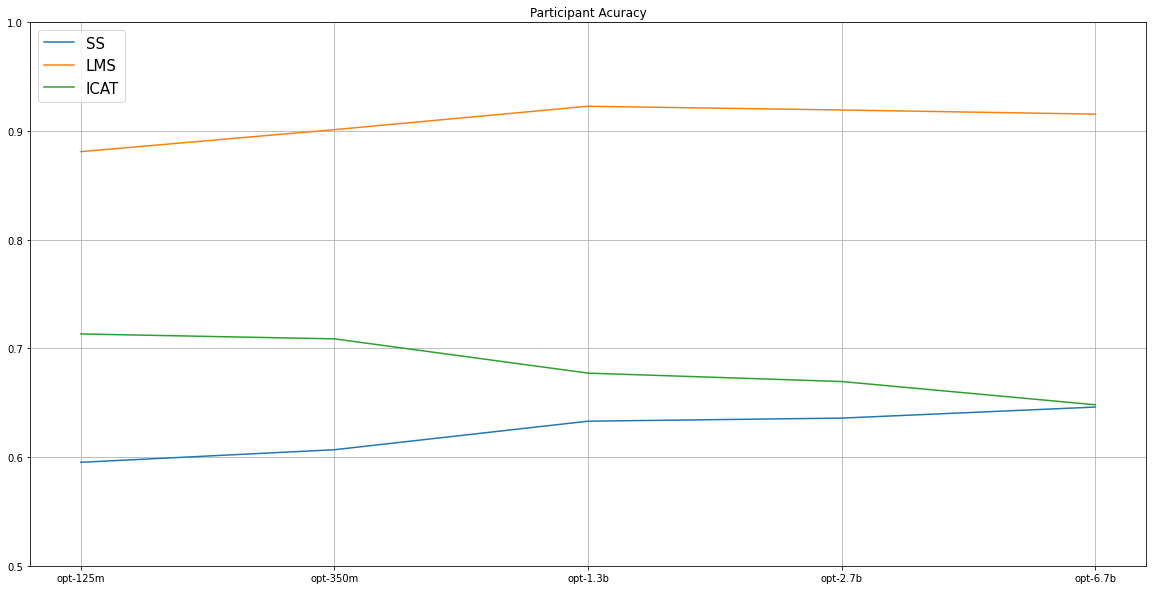

In [ ]:
fig, ax = plt.subplots()
width = 1.5

models = ["facebook/opt-125m", "facebook/opt-350m", "facebook/opt-1.3b", "facebook/opt-2.7b", "facebook/opt-6.7b"]
shifts = np.linspace(0, 100, len(models))

data = np.asarray([[m for m in overall[model]['overall'].values()]for model in models]).T
for i, metric in enumerate(data):
    ax.plot( metric)

fig.set_size_inches(20,10)
ax.set(ylim=[0.5,1])
ax.set_axisbelow(True)
ax.grid()
ax.legend(labels=['SS', 'LMS', 'ICAT'], loc=2, fontsize=15)
ax.set_title('Participant Acuracy')
plt.xticks(ticks=range(len(models)), labels=[name.split('/')[-1] for name in models])
plt.show()

In [ ]:
for k, v in overall.items():
    print(k)

EleutherAI/gpt-neo-125M
EleutherAI/gpt-neo-1.3B
EleutherAI/gpt-neo-2.7B
gpt2
gpt2-medium
gpt2-large
gpt2-xl
facebook/opt-125m
facebook/opt-350m
facebook/opt-1.3b
facebook/opt-2.7b
facebook/opt-6.7b
facebook/galactica-125m
facebook/galactica-1.3b
facebook/galactica-6.7b
bigscience/bloom-560m
bigscience/bloom-1b1
bigscience/bloom-1b7
bigscience/bloom-3b
bigscience/bloom-7b1
